# Анализ комментариев оппозиционного ютуба

## Введение

Иногда хочется простого

## Технические моментики

### Установка зависимостей

In [2]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [3]:
import pandas as pd
import numpy as np
import scipy.stats as sts

import re
import time
from tqdm import tqdm
import datetime
import sqlite3
from collections import defaultdict

### Для того, чтобы загружать файлы с ЯД
from urllib.parse import urlencode
from urllib.request import urlretrieve
import requests

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_theme(style='darkgrid')

In [4]:
'''
Эта функция нужна, чтобы подгружать файлы с Яндекс Диска.
Принцип подсмотрел тут:
https://thgtsprog.blogspot.com/2020/06/csv-c.html
'''
def from_yaDisk(link):
    yadisk = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    response = requests.get(yadisk + urlencode({'public_key': link}))
    return response.json()['href']

### Подгружаем базу данных

In [5]:
local_db = 'db.db' # создаем локальное имя

urlretrieve(from_yaDisk('https://disk.yandex.ru/d/Q6113g0lizxkvw'), local_db) # скачиваем файл с ЯД

# Подключаемся к базе
sql_conn = sqlite3.connect(local_db)
cursor = sql_conn.cursor()

### Немного технических функций, чтоб красиво было

In [6]:
channels_id = pd.read_json(from_yaDisk('https://disk.yandex.ru/d/0DkqqDrltIPAgg'))
channels_id = channels_id.set_index('id')

In [7]:
def channel_name(userid):
    """
    Во всех базах каналы можно выделить по
    их id. Эта функция переводит id в
    читаемое название
    """
    global channels_id
    l = channels_id.loc[userid, 'links']

    custom_url = r'https?://(?:www\.)?youtube\.com/@([A-Za-zА-я0-9_-]+)'

    return re.match(custom_url, l).group(1)

## Предварительная обработка данных

### Для начала, посмотрим, есть ли в базе данных пропуки вообще

In [8]:
### извлечём название столбцов
def columns_for_where():
    cursor.execute('PRAGMA table_info(comments)')
    df_columns = [i[1] for i in cursor.fetchall()]
    return " ISNULL OR ".join(df_columns) + " ISNULL"

cursor.execute(f'SELECT * FROM comments WHERE {columns_for_where()}')
cursor.fetchall()

[]

Как видим, в базе нет пропусков (еще бы они были, учитывая, как она собиралась). Посмотрим, какие столбцы у нас есть

### Опишем отслеживаемые параметры

In [9]:
cursor.execute('PRAGMA table_info(comments)')
cursor.fetchall()

[(0, 'channelId', 'TEXT', 1, None, 0),
 (1, 'videoId', 'TEXT', 1, None, 0),
 (2, 'userId', 'TEXT', 1, None, 0),
 (3, 'videoDate', 'DATETIME', 0, None, 0),
 (4, 'commentDate', 'DATETIME', 0, None, 0),
 (5, 'commentText', 'TEXT', 1, None, 0),
 (6, 'likeCount', 'INTEGER', 0, None, 0),
 (7, 'totalReplyCount', 'INTEGER', 0, None, 0)]

1. channelId -- столбец содержит в себе уникальный идентификатор канала, тип данных -- str
2. videoId -- в этом столбце содержаться уникальые идентификаторы видео, тип данных -- str
3. userId -- тут содержатся идентификаторы комментаторов
4. videoDate -- дата выхода видео, datetime
5. commentDate -- дата публикации комментария, datetime
6. commentText -- текст комментария
7. likeCount -- счетчик лайков под комментариями
8. totalReplyCount -- счетчик ответов под комментариями

## Переходим в pandas и создаем новые признаки

### Переход к pandas

In [154]:
cursor.execute('SELECT DISTINCT channelId from comments')
channels = list(list(zip(*cursor.fetchall()))[0])
df = pd.read_sql_query('SELECT * FROM comments', sql_conn) ### делаем sql-запрос и считываем его в DataFrame

In [155]:
def rplc(s):
  return s.replace('+00:00', '')

In [156]:
df['videoDate'] = df['videoDate'].apply(rplc).astype('datetime64[s]')
df['commentDate'] = pd.to_datetime(df['commentDate']).dt.tz_localize(None)
df['commentDate'] = df['commentDate'].astype('datetime64[ns]')

In [157]:
df.head(3)

,channelId,videoId,userId,videoDate,commentDate,commentText,likeCount,totalReplyCount
0,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UC2diJqEViME5uo5ZG7XrCQg,2025-03-15 11:10:24,2025-03-15 12:51:18,В одном из выступлений Зеленский выразил своё ...,0,0
1,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UC5b1UGWXS6p31JGnxjUwGMg,2025-03-15 11:10:24,2025-03-15 12:47:44,Явлинский как всегда и на елку хочет влезть и ...,0,0
2,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UCQrSu4s5smVN6PRSR1-3Ygw,2025-03-15 11:10:24,2025-03-15 12:44:37,"Раньше я господина Явлинского не долюбливал, к...",1,0


### Создаем новые признаки

У нас есть даты и время публикаций видео и комментариев, а также сам текст комментария. Таким образом, можем добавить несколько дополнительных признаков:
1. Разность между временами выхода видео и публикации комментария
2. Длина комментария
3. Номер дня недели, когда опубликован комментарий, где 0 -- понедельник, 6 -- воскресенье
Эти признаки я собираюсь в дальнейшем использовать для оценки того, с какой вероятностью комментарий вызовет дискуссию

In [158]:
def textlen(comm):
    comm = comm.lower()
    comm = re.sub(r'\d+', '', comm)
    comm = re.sub(r'[^\w\s]', '', comm)
    return len(comm.split(' '))

def weektime(date):
    start_week = date - pd.Timedelta(days=date.weekday())
    return (date - start_week.normalize()).total_seconds()

def weekday(date):
    return ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'][date.weekday()]

In [159]:
df['commentLag'] = df['commentDate'].values - df['videoDate'].values
df['commentLen'] = df['commentText'].apply(textlen)
df['weektimeComm'] = df['commentDate'].apply(weektime)
df['weektimeVideo'] = df['videoDate'].apply(weektime)
df['weekDayComm'] = df['commentDate'].apply(weekday)

# технические параметры
df['channel'] = df['channelId'].apply(channel_name)

df.head(3)

,channelId,videoId,userId,videoDate,commentDate,commentText,likeCount,totalReplyCount,commentLag,commentLen,weektimeComm,weektimeVideo,weekDayComm,channel
0,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UC2diJqEViME5uo5ZG7XrCQg,2025-03-15 11:10:24,2025-03-15 12:51:18,В одном из выступлений Зеленский выразил своё ...,0,0,0 days 01:40:54,19,478278.0,472224.0,Сб,zhivoygvozd
1,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UC5b1UGWXS6p31JGnxjUwGMg,2025-03-15 11:10:24,2025-03-15 12:47:44,Явлинский как всегда и на елку хочет влезть и ...,0,0,0 days 01:37:20,25,478064.0,472224.0,Сб,zhivoygvozd
2,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UCQrSu4s5smVN6PRSR1-3Ygw,2025-03-15 11:10:24,2025-03-15 12:44:37,"Раньше я господина Явлинского не долюбливал, к...",1,0,0 days 01:34:13,22,477877.0,472224.0,Сб,zhivoygvozd


### Посмотрим на commentLag
Время между выходом видео и публикацией комментария записана в столбец commentLag. Однако комментарии можно оставлять не только под видео, но и под стримами, которые от видео в таблице неотличимы. Найдем такие комментарии, и удалим их, поскольку они будут сильно искажать нашу выборку

In [168]:
(df['commentLag'] <= np.timedelta64(0)).sum()

np.int64(0)

In [167]:
df.drop(df[df['commentLag'] <= np.timedelta64(0)].index, inplace=True)
df.head()

,channelId,videoId,userId,videoDate,commentDate,commentText,likeCount,totalReplyCount,commentLag,commentLen,weektimeComm,weektimeVideo,weekDayComm,channel
0,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UC2diJqEViME5uo5ZG7XrCQg,2025-03-15 11:10:24,2025-03-15 12:51:18,В одном из выступлений Зеленский выразил своё ...,0,0,0 days 01:40:54,19,478278.0,472224.0,Сб,zhivoygvozd
1,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UC5b1UGWXS6p31JGnxjUwGMg,2025-03-15 11:10:24,2025-03-15 12:47:44,Явлинский как всегда и на елку хочет влезть и ...,0,0,0 days 01:37:20,25,478064.0,472224.0,Сб,zhivoygvozd
2,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UCQrSu4s5smVN6PRSR1-3Ygw,2025-03-15 11:10:24,2025-03-15 12:44:37,"Раньше я господина Явлинского не долюбливал, к...",1,0,0 days 01:34:13,22,477877.0,472224.0,Сб,zhivoygvozd
3,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UCzaanybiST-Wq58x_A5EGLA,2025-03-15 11:10:24,2025-03-15 12:44:25,"Патока и елей, Европа никуда не годна,Трамп мо...",0,0,0 days 01:34:01,13,477865.0,472224.0,Сб,zhivoygvozd
4,UCWAIvx2yYLK_xTYD4F2mUNw,UR8fy4-WFDQ,UCThmJkK84pPXYnXci3U94mA,2025-03-15 11:10:24,2025-03-15 12:42:01,Хочется задать один вопрос Явлинскому. Вы не х...,1,1,0 days 01:31:37,26,477721.0,472224.0,Сб,zhivoygvozd


In [169]:
(df['commentLag'] <= np.timedelta64(0)).sum()

np.int64(0)

## Предварительный и визуальный анализ

Для начала, по всем каналам, построим гистограммы распределений задержки комментирования, длины комментария и количества ответов на комментариях

<ipython-input-184-c16da4fa8c1a>:19: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(df['totalReplyCount'].values),


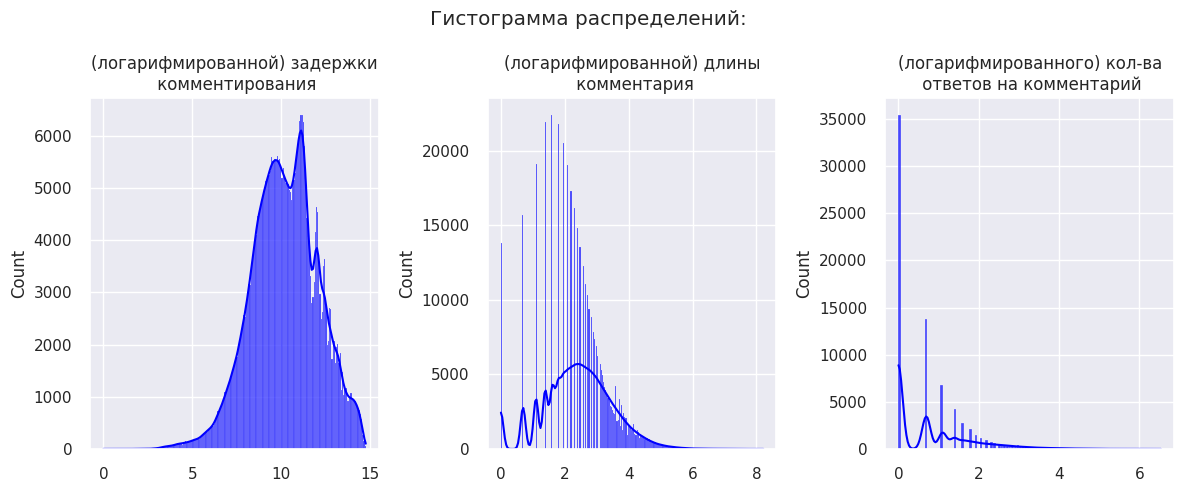

In [184]:
plt.figure(figsize=(12, 5))
plt.suptitle('Гистограмма распределений: ')

# Распределение задержки комментирования
plt.subplot(1, 3, 1)
plt.title('(логарифмированной) задержки\n комментирования')
sns.histplot(np.log(df['commentLag'].dt.total_seconds().values),
             kde=True, alpha=.7, color='blue')

# Распределение длин комментариев
plt.subplot(1, 3, 2)
plt.title('(логарифмированной) длины\n комментария')
sns.histplot(np.log(df['commentLen'].values),
             kde=True, alpha=.7, color='blue')

# Распределение количества ответов на коммментарии
plt.subplot(1, 3, 3)
plt.title('(логарифмированного) кол-ва\n ответов на комментарий')
sns.histplot(np.log(df['totalReplyCount'].values),
             alpha=.7, color='blue', kde=True);
plt.tight_layout();

Видно, что задержка комментирования и длина комментариев похожи на логнормальные (шум в низких значениях длин комментариев объясняется тем, что хоть сколь-нибудь осмысленный комментарий сложно написать из менее чем $\sim e^3$ слов).
Количество ответов на комментарий при логарифмировании стал более медленно снижаться, но общий Паттерн сохранил. Это говорит о том, что их распределение, вероятно, описывается степенной функцией распределения.

На слеждующих графиках можно посмотреть, что для отдельных каналов закономерность сохраняется. Эта часть не очень информативная, ее можно пропустить. Также в ней в DataFrame добавляются логарифмированные столбцы с зфдержкой комментирования и длиной комментария

### Распределения для отдельных каналов

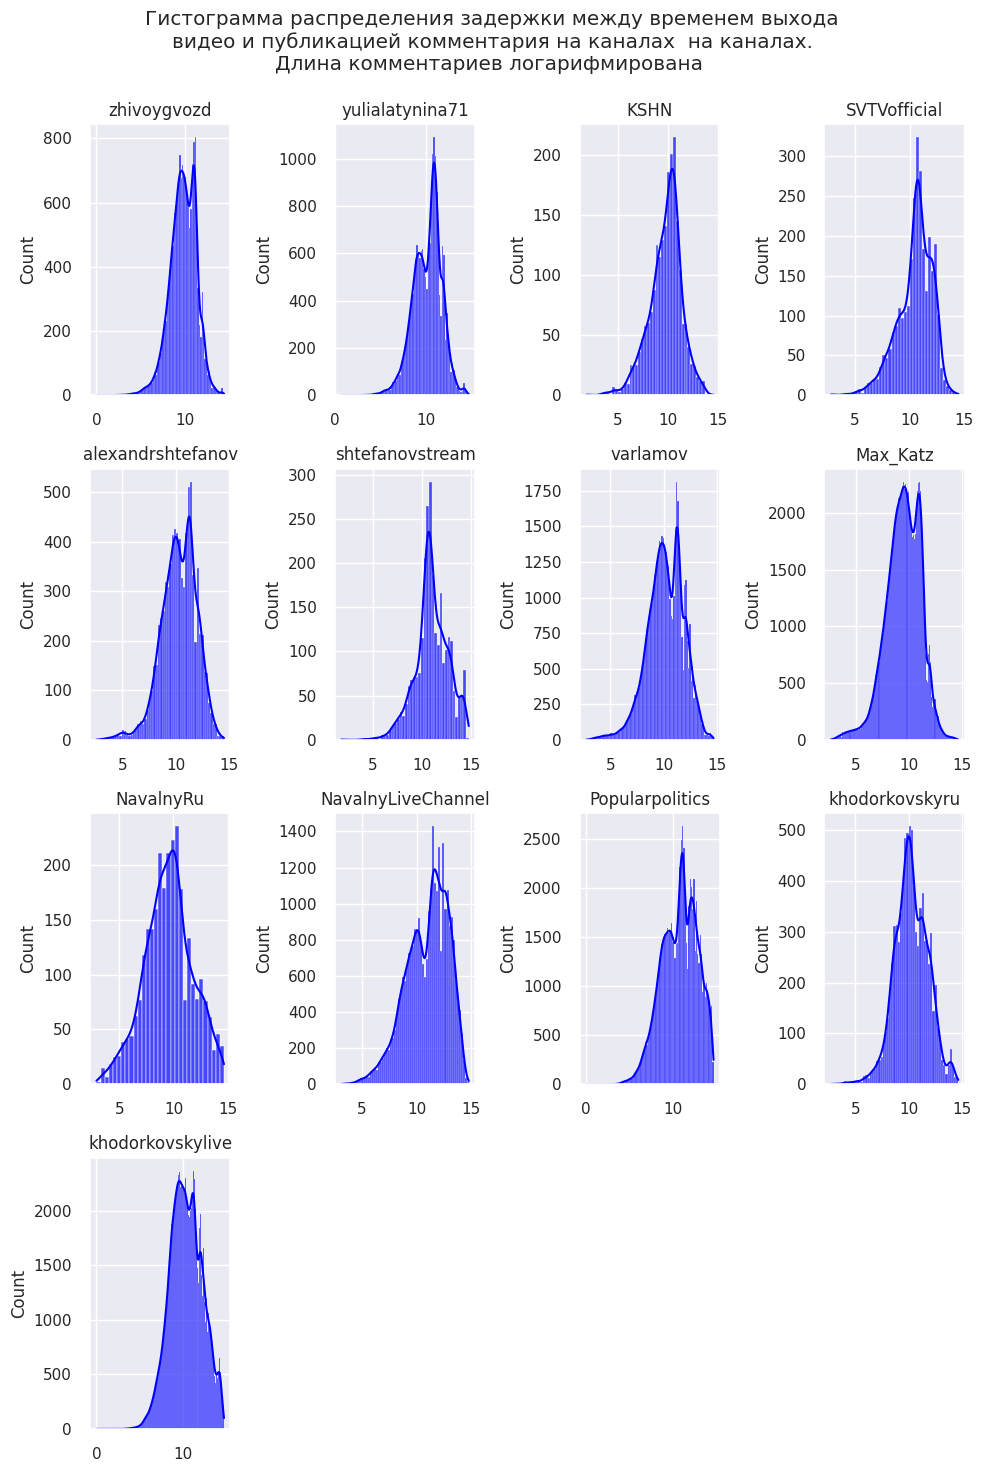

In [181]:
plt.figure(figsize=(10, 15))
plt.suptitle('Гистограмма распределения задержки между временем выхода\n' +
             'видео и публикацией комментария на каналах  на каналах.\n' +
             'Длина комментариев логарифмирована \n')
for k, i in enumerate(channels):
    plt.subplot(4, 4, k+1)
    plt.title(channel_name(i))
    sns.histplot(np.log(df[df['channelId'] == i]['commentLag'].dt.total_seconds().values),
             kde=True, alpha=.7, color='blue')

plt.tight_layout()

Для начала, будем смотреть на всю выборку, без разбивания на отдельные каналы или группы каналов.

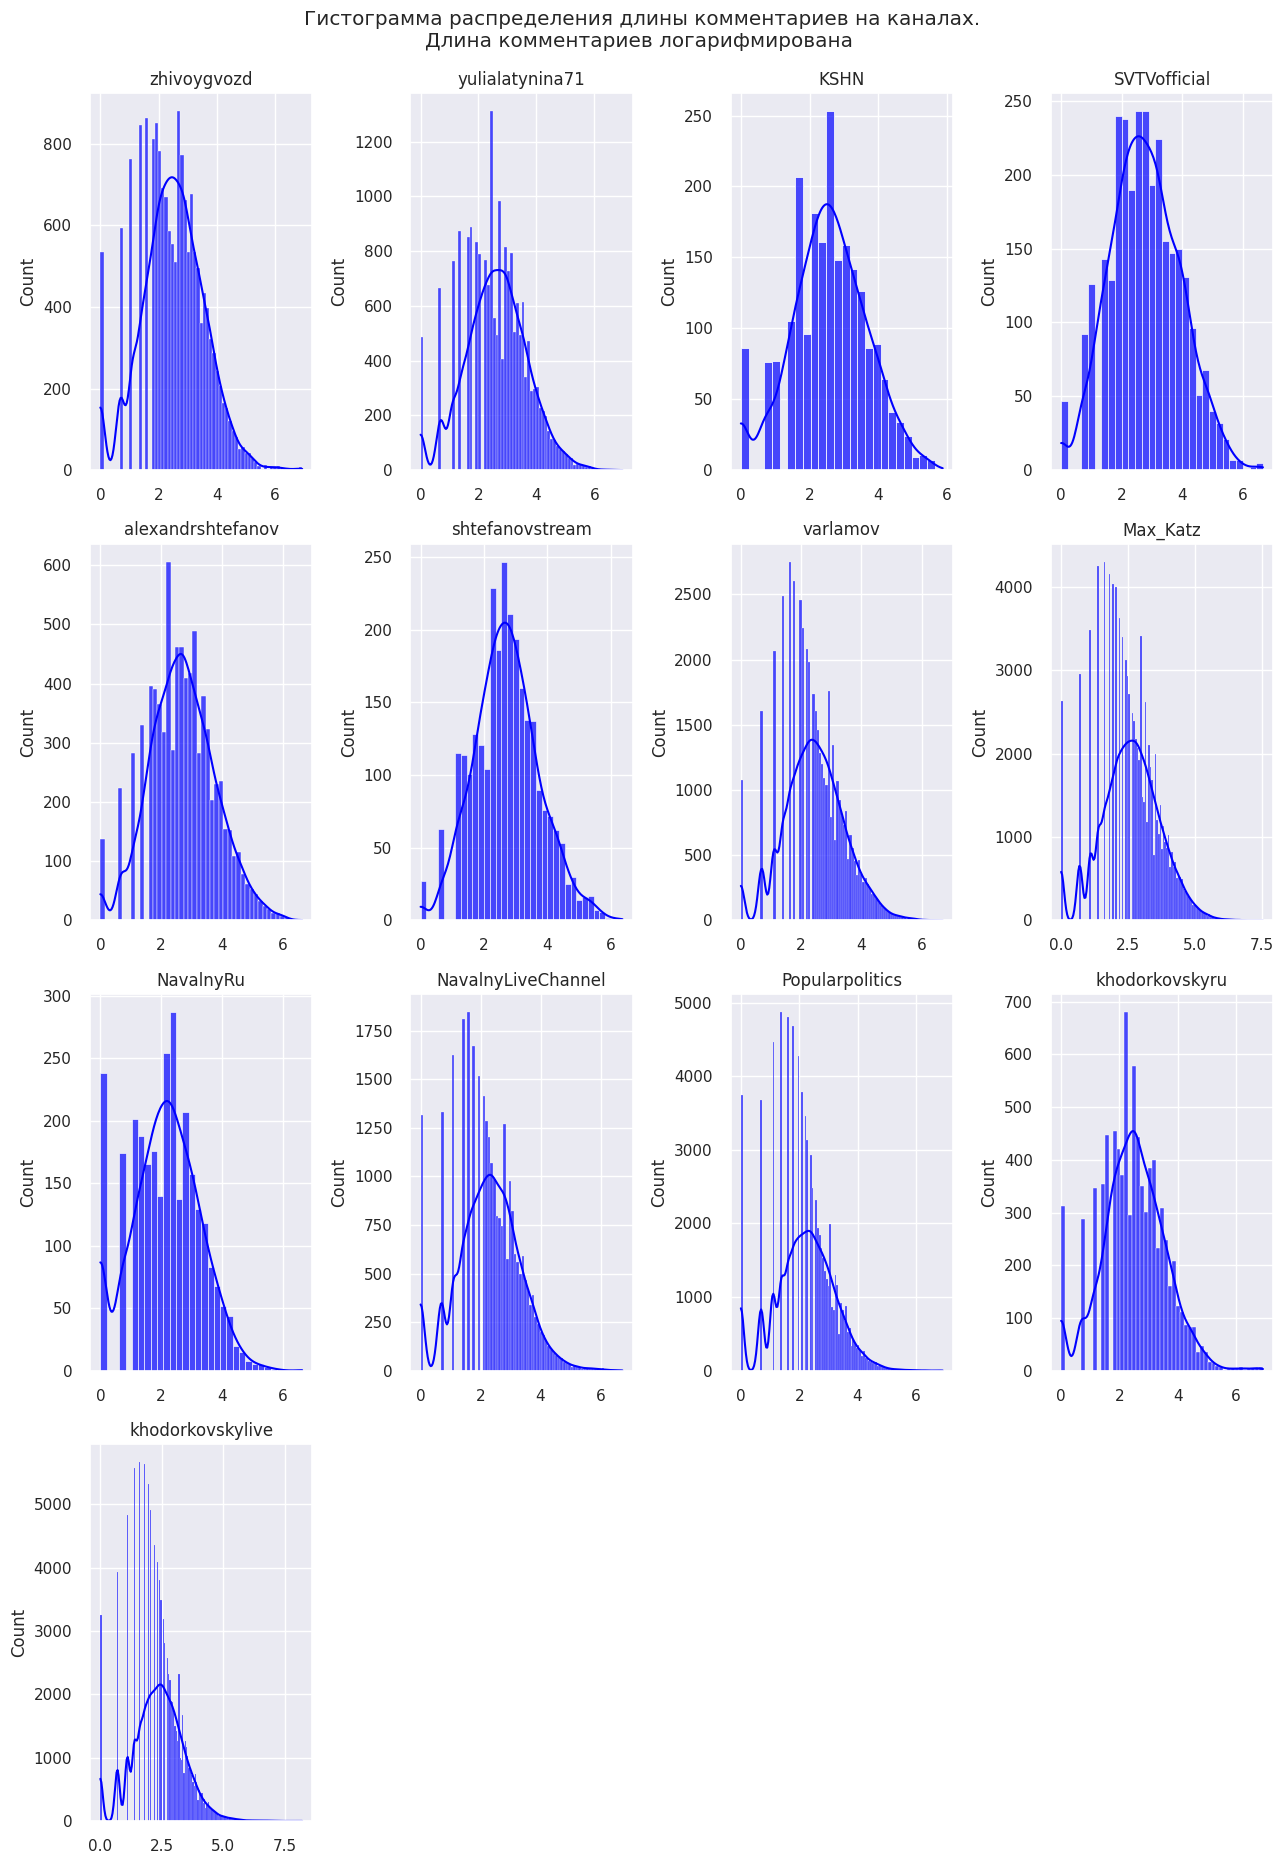

In [13]:
plt.figure(figsize=(13, 19))
plt.suptitle('Гистограмма распределения длины комментариев на каналах.\n' +
             'Длина комментариев логарифмирована \n')
for k, i in enumerate(channels):
    plt.subplot(4, 4, k+1)
    plt.title(channel_name(i))
    sns.histplot(np.log(df[df['channelId'] == i]['commentLen'].values),
             kde=True, alpha=.7, color='blue')

plt.tight_layout()

<ipython-input-14-7d218a6abd53>:7: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(df[df['channelId'] == i]['totalReplyCount'].values),
<ipython-input-14-7d218a6abd53>:7: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(df[df['channelId'] == i]['totalReplyCount'].values),
<ipython-input-14-7d218a6abd53>:7: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(df[df['channelId'] == i]['totalReplyCount'].values),
<ipython-input-14-7d218a6abd53>:7: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(df[df['channelId'] == i]['totalReplyCount'].values),
<ipython-input-14-7d218a6abd53>:7: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(df[df['channelId'] == i]['totalReplyCount'].values),
<ipython-input-14-7d218a6abd53>:7: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(df[df['channelId'] == i]['totalReplyCount'].values),
<ipython-input-14-7d218a6abd53>:7: Runti

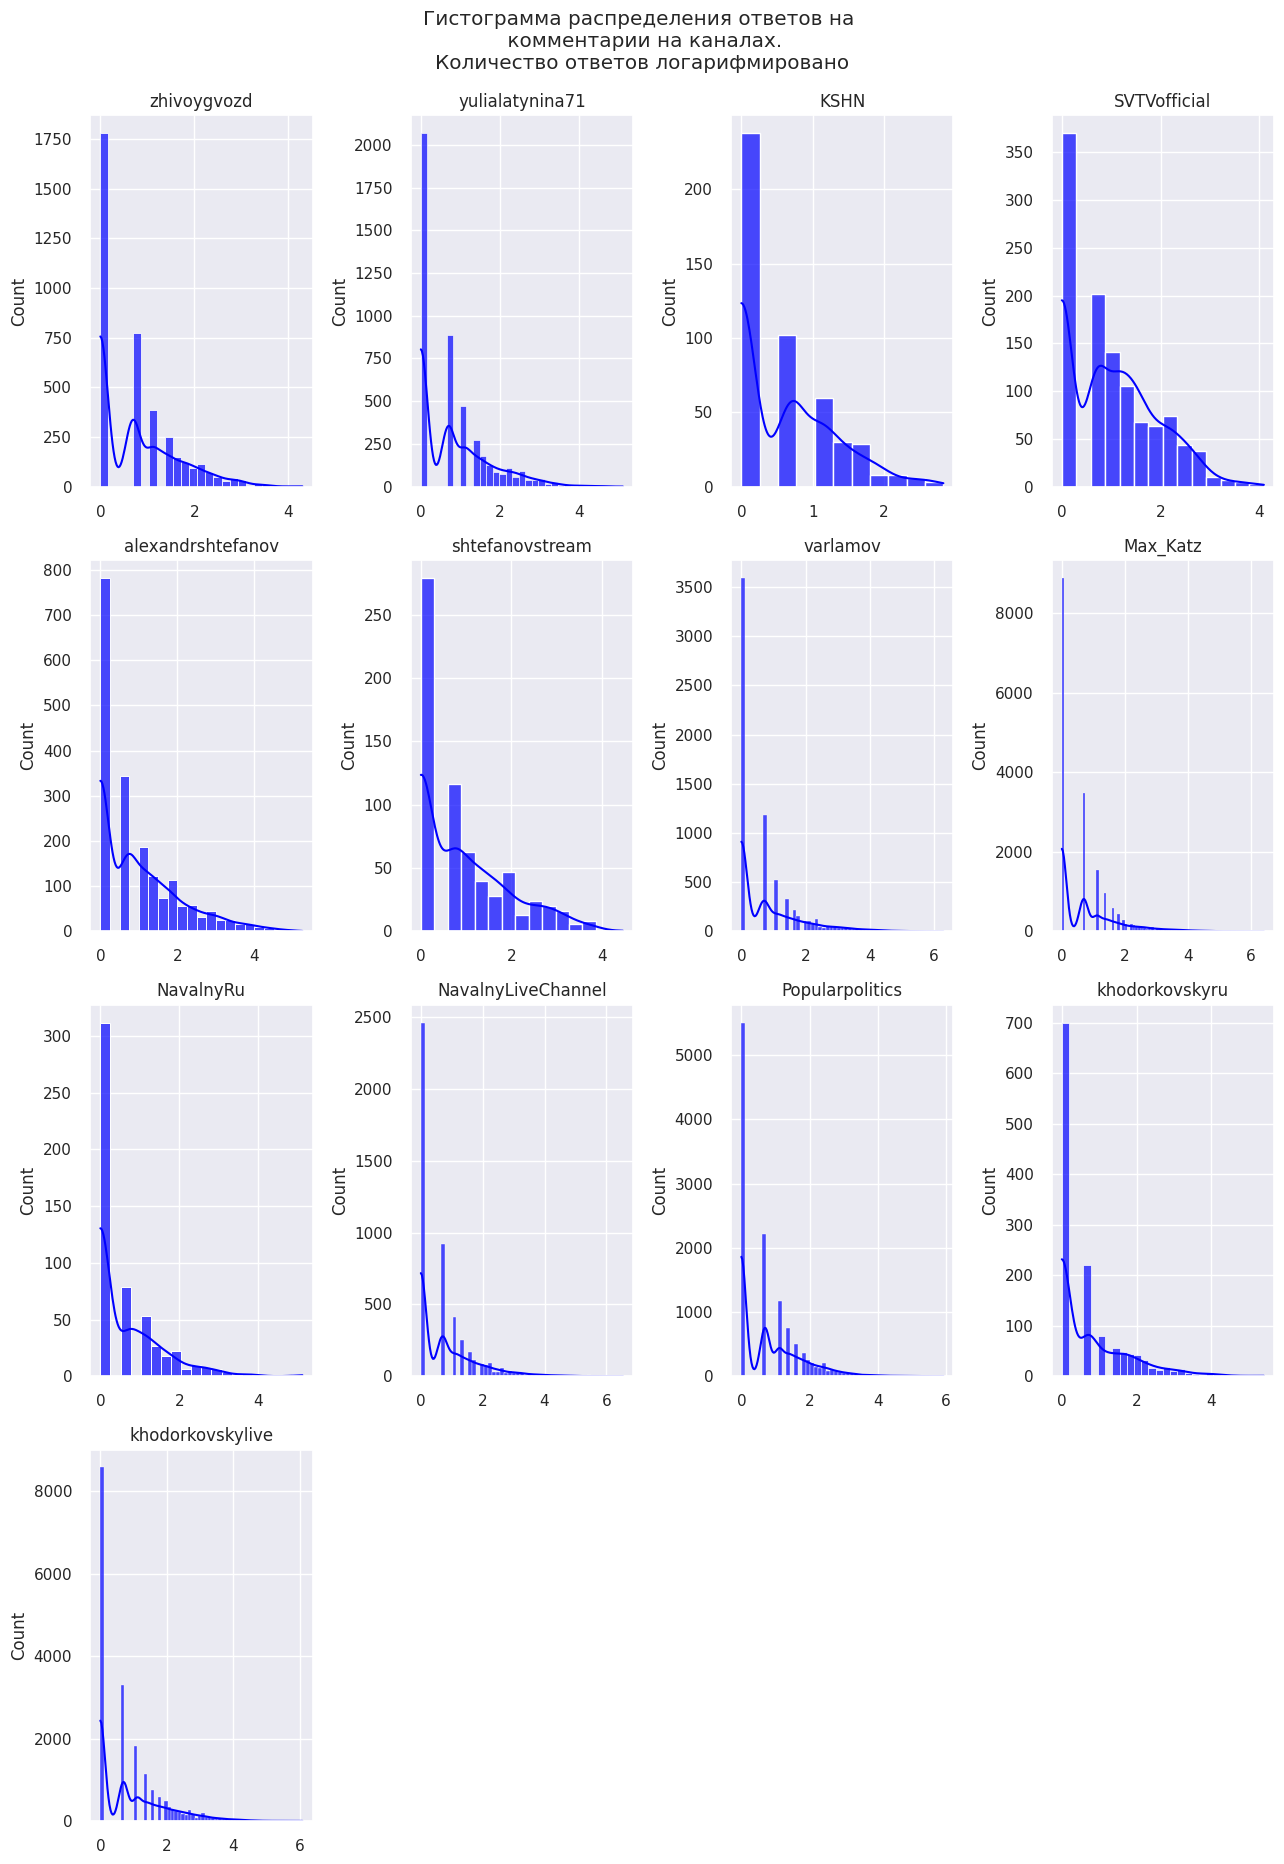

In [14]:
plt.figure(figsize=(13, 19))
plt.suptitle('Гистограмма распределения ответов на \n комментарии на каналах.\n' +
             'Количество ответов логарифмировано\n')
for k, i in enumerate(channels):
    plt.subplot(4, 4, k+1)
    plt.title(channel_name(i))
    sns.histplot(np.log(df[df['channelId'] == i]['totalReplyCount'].values),
             alpha=.7, color='blue', kde=True);

plt.tight_layout();

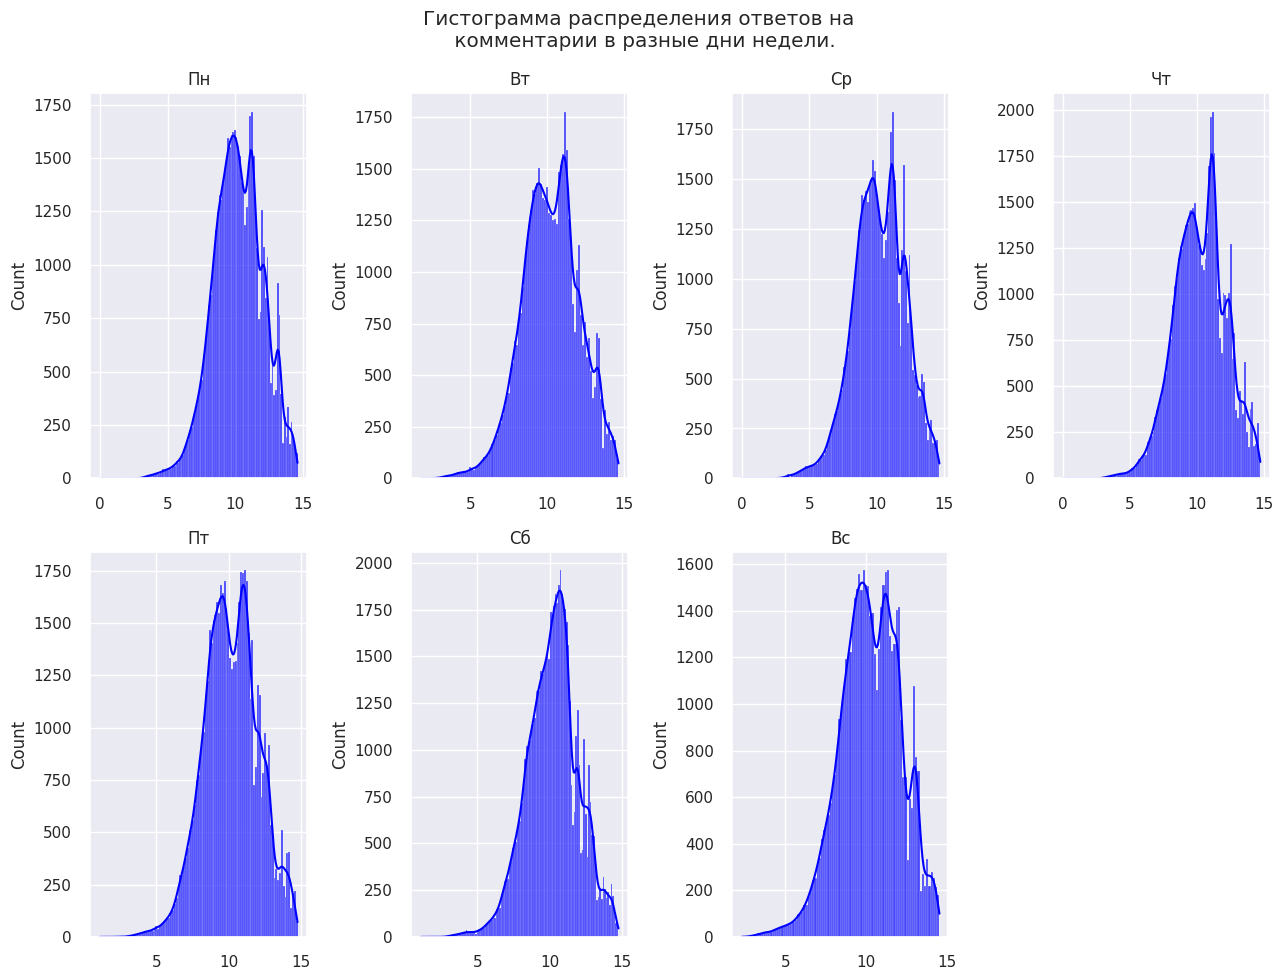

In [192]:
plt.figure(figsize=(13, 19))
plt.suptitle('Гистограмма распределения ответов на \n комментарии в разные дни недели.\n')
w = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
for k, i in enumerate(w):
    plt.subplot(4, 4, k+1)
    plt.title(w[k])
    vec = np.log(df[df['weekDayComm'] == i]['commentLag'].dt.total_seconds().values);
    sns.histplot(vec,
             alpha=.7, color='blue', kde=True);

plt.tight_layout();

In [190]:
df['commentLagLog'] = np.log(df['commentLag'].dt.total_seconds().values)
df['commentLenLog'] = np.log(df['commentLen'])

### Сделаем Scatterplot Matrix

In [ ]:
def ScMx(data):
    data = data[['likeCount', 'totalReplyCount',
                'commentLenLog', 'weekDayComm',
                'commentLagLog']]
    sns.pairplot(data,
                 hue='likeCount')

ScMx(df)

In [ ]:
def gen_labels(df_input):
    df['time'] = pd.to_datetime(df_input['weektimeComm'], unit='s', origin=monday)

In [ ]:
def histWeektimeComm(arr, title):
    plt.title(title)
    plt.hist(arr)
    #plot = sns.histplot(arr, x="revenue", bins=500)
    #plot.set(xlabel='Время с начала недели', \
    #         ylabel='Количество комментариев')

#histWeektimeComm(df['weektimeComm'], 'Гистограмма распределения количества комментариев по дням недели')
plot = sns.histplot(df['weektimeComm'], bins=1000);
plot.set(xlabel='Время с начала недели', \
         ylabel='Количество комментариев')


### Разминка на гистограммах

In [ ]:
def histsCommentLen(arr, title):
    plt.title(title)
    plot = sns.histplot(arr)
    plot.set(xlabel='Длина комментария', \
             ylabel='Количество комментариев')

In [ ]:
histsCommentLen(df['commentLen'], 'Гистограмма распределения длинн комментариев')

## Анализ пересечения аудиторий

Попробуем оценить пересечения аудиторий каналов. Для этого, сначала узнаем, сколько вообще в выборке каналов

In [ ]:
print(f'Всего в выборке {len(channels)} каналов')

Для каждого из каналов выведем множество уникальных комментаторов

In [ ]:
unical_commentators = defaultdict(list)

for i in channels:
    cursor.execute(f'SELECT DISTINCT userId from comments WHERE channelId="{i}"')
    unical_commentators[i] = list(list(zip(*cursor.fetchall()))[0])

In [ ]:
def commentators_bar(ch_dict):
    chan = list(ch_dict.keys())
    lens = []
    for i in chan:
        lens.append(len(ch_dict[i]))

    chan = np.array(chan)
    plt.figure(figsize=(14, 8))
    plt.title('Каналы в разрезе уникальных комментаторов')
    plt.bar(np.vectorize(channel_name)(chan), lens)
    plt.ylabel('Количество уникальных комментаторов канала')
    plt.xticks(rotation=45)
    plt.show();

In [ ]:
commentators_bar(unical_commentators)